In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import ncdl
import os
import ncdl.nn as ncnn
from PIL import Image
from typing import Optional, Callable
from ncdl.nn.functional.downsample import downsample
from ncdl.nn.functional.upsample import upsample
from ncdl import pad_like
from utility import visualize_lattice
from torchsummary import summary

class CustomDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
        self.mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        mask = Image.open(self.mask_paths[idx]).convert('L')

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

transform = transforms.Compose([
    transforms.Resize((572, 572)),
    transforms.ToTensor()
])

train_image_dir = '/path/to/the/data'
train_mask_dir = '/path/to/the/data'
test_image_dir = '/path/to/the/data'
test_mask_dir = '/path/to/the/data'

batch_size = 8

train_dataset = CustomDataset(train_image_dir, train_mask_dir, transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_size = int(0.2 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

test_dataset = CustomDataset(test_image_dir, test_mask_dir, transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# LatticeNormalizationWrapper class is from the following:
'''Horacsek, J. (2023). *Non-Cartesian Deep Learning (NCDL)* [Source code]. GitHub. 
   https://github.com/jjh13/NCDL/tree/master/ncdl'''
class LatticeNormalizationWrapper(nn.Module):
    def __init__(self, lattice, channels, normalization):
        super(LatticeNormalizationWrapper, self).__init__()
        assert normalization in [None, 'bn', 'gn', 'in']
        if normalization is None:
            self.module = nn.Identity()
        elif normalization == 'bn':
            self.module = ncnn.LatticeBatchNorm(lattice, channels)
        elif normalization == 'in':
            self.module = ncnn.LatticeInstanceNorm(lattice, channels)
        elif normalization == 'gn':
            group_size = [group_size for group_size in [8,4,2,1] if channels % group_size == 0][0]
            self.module = ncnn.LatticeGroupNorm(lattice, channels//group_size, channels)

    def forward(self, x):
        return self.module(x)

    
class NCDL(nn.Module):
    def __init__(self, lattice: ncdl.Lattice, num_classes=10):
        super().__init__()
        
        self.lattice = lattice

        if lattice == ncdl.Lattice("qc"):
            stencil = ncdl.Stencil([
                (1, 1), (2, 2), (3, 1), (1, 3), (3, 3), (0, 2), (2, 0), (2, 4), (4, 2)

            ], lattice, center=(2, 2))
            
        # encoder
        self.layer2 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout())
        self.layer3 = nn.Sequential(
            ncnn.LatticePad(lattice, stencil),
            ncnn.LatticeConvolution(lattice, channels_in=64, channels_out=128, stencil=stencil, bias=False),
            LatticeNormalizationWrapper(lattice, 128, 'bn'),
            ncnn.LeakyReLU())
        self.layer6 = nn.Sequential(
            ncnn.LatticeUnwrap(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout())
        self.layer7 = nn.Sequential(
            ncnn.LatticePad(lattice, stencil),
            ncnn.LatticeConvolution(lattice, channels_in=256, channels_out=512, stencil=stencil, bias=False),
            LatticeNormalizationWrapper(lattice, 512, 'bn'),
            ncnn.LeakyReLU())
        self.layer10 = nn.Sequential(
            ncnn.LatticeUnwrap(),
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout())
        
        # bottleneck
        self.layer11 = nn.Sequential(
            nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(),
            nn.Dropout())
        self.layer12 = nn.Sequential(
            nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(),
            nn.Dropout())
        
        # decoder
        self.layer20 = nn.Sequential(
            ncnn.LatticeConvolution(lattice, channels_in=1024, channels_out=512, stencil=stencil, bias=False),
            LatticeNormalizationWrapper(lattice, 512, 'bn'),
            ncnn.LeakyReLU())
        self.layer21 = nn.Sequential(
            ncnn.LatticeUnwrap(),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=0, output_padding=1))
        self.layer21sub = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Dropout())
        self.layer24 = nn.Sequential(
            ncnn.LatticeConvolution(lattice, channels_in=256, channels_out=128, stencil=stencil, bias=False),
            LatticeNormalizationWrapper(lattice, 128, 'bn'),
            ncnn.LeakyReLU())     
        self.layer25 = nn.Sequential(
            ncnn.LatticeUnwrap(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=0, output_padding=1))
        self.layer25sub = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout())
        self.layer26 = nn.Sequential(
            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=2, padding=0, output_padding=1),  
            nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1),
            nn.LeakyReLU(),
            nn.Dropout())
        
        self.layer27 = nn.Sequential(
            nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(1),
            nn.LeakyReLU())
        
    def forward(self, x):
        layer = ncnn.LatticeWrap()
        
        out4 = self.layer2(x)
        out = layer(out4)
        restore1 = downsample(out, np.array([[-1, 1], [1, 1]], dtype='int'))
        out3 = self.layer3(restore1)
        out2 = self.layer6(out3)
        out = layer(out2)
        restore3 = downsample(out, np.array([[-1, 1], [1, 1]], dtype='int'))
        out1 = self.layer7(restore3)
        out = self.layer10(out1)
        restore4 = layer(out)
        restore4 = downsample(restore4, np.array([[-1, 1], [1, 1]], dtype='int'))

        # bottleneck
        out = self.layer11(out)
        out = self.layer12(out)

        # upsample
        out = layer(out)
        out = upsample(out, np.array([[-1, 1], [1, 1]], dtype='int'))
        out = pad_like(out, restore4)
        out = self.layer20(out)
        out = self.layer21(out)
        out = nn.functional.interpolate(out, size=(71, 71), mode='bilinear', align_corners=False)
        out = torch.cat([out, out2], dim=1)
        out = self.layer21sub(out)
        out = layer(out)
        out = upsample(out, np.array([[-1, 1], [1, 1]], dtype='int'))
        out = pad_like(out, restore3)
        out = self.layer24(out)
        out = self.layer25(out)
        out = nn.functional.interpolate(out, size=(286, 286), mode='bilinear', align_corners=False)
        out = torch.cat([out, out4], dim=1)
        out = self.layer25sub(out)
        out = self.layer26(out)
        out = self.layer27(out)
        return out
    
    
lattice = ncdl.Lattice("qc")
model = NCDL(lattice)

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")

def calculate_pixel_accuracy(outputs, masks):
    outputs = torch.sigmoid(outputs)  
    preds = outputs > 0.5  
    correct = (preds == masks).sum().item()
    total = torch.numel(preds)
    return correct / total

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        if outputs.shape != masks.shape:
            print(f"Shape mismatch: outputs {outputs.shape}, masks {masks.shape}")
        
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in valid_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)

    val_loss /= len(valid_loader.dataset)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}")

model.eval()
test_loss = 0.0
with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, masks)
        test_loss += loss.item() * images.size(0)

test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss}")



Number of parameters: 32677849
Number of trainable parameters: 32677849


/home/sua.lim/work/ncdl/NCDL/ncdl/nn/functional/convolution.py:79: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return convolution[_lattice.dimension](data, weights, padding=0, groups=groups)
/home/sua.lim/.local/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/10, Train Loss: 0.27542993560985807, Validation Loss: 0.2669295709138798
Epoch 2/10, Train Loss: 0.25837681751623687, Validation Loss: 0.2485839351376086
Epoch 3/10, Train Loss: 0.23795536249244184, Validation Loss: 0.2389422977987624
Epoch 4/10, Train Loss: 0.22876505305752093, Validation Loss: 0.22419639714238768
Epoch 5/10, Train Loss: 0.2218803145281726, Validation Loss: 0.22395771068136838
Epoch 6/10, Train Loss: 0.2160731022810182, Validation Loss: 0.211684951835899
Epoch 7/10, Train Loss: 0.20040134056285422, Validation Loss: 0.15522431831506756
Epoch 8/10, Train Loss: 0.1611524715562518, Validation Loss: 0.12949156477270532
Epoch 9/10, Train Loss: 0.14955526342906475, Validation Loss: 0.13572902097521236
Epoch 10/10, Train Loss: 0.14498400620575216, Validation Loss: 0.1255676467977994
Test Loss: 0.12390541237327866


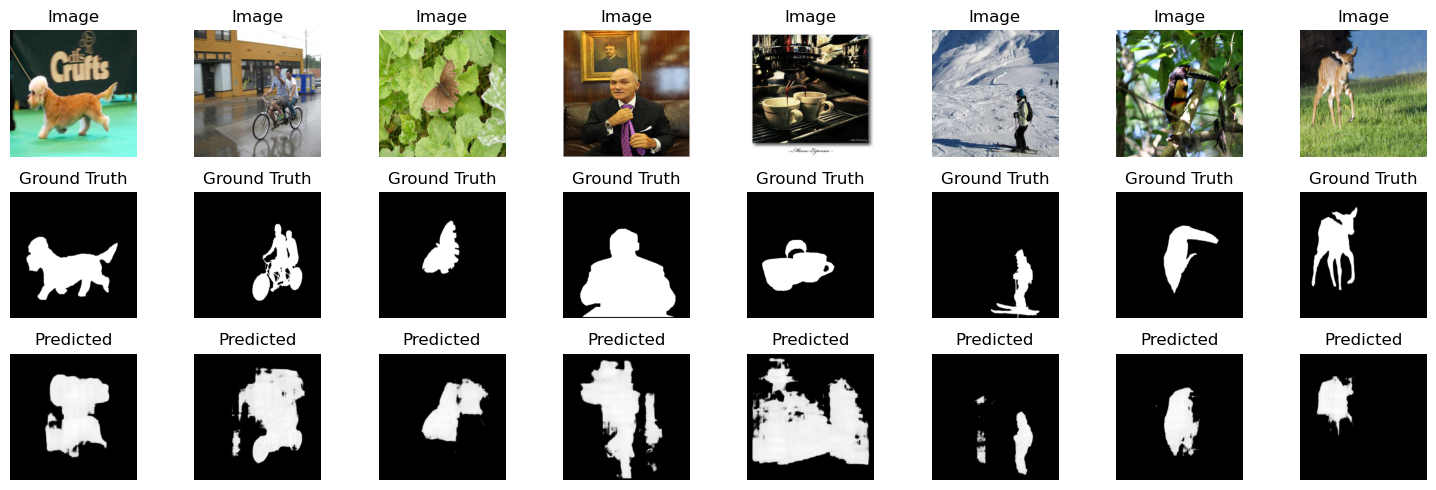

Test Loss: 0.00025497244642506663


In [2]:
import matplotlib.pyplot as plt

def visualize_predictions(images, masks, outputs, idx):
    images = images.cpu().numpy().transpose(0, 2, 3, 1)
    masks = masks.cpu().numpy()
    outputs = torch.sigmoid(outputs).cpu().numpy()

    fig, axs = plt.subplots(3, len(images), figsize=(15, 5))

    for i in range(len(images)):
        axs[0, i].imshow(images[i])
        axs[0, i].set_title('Image')
        axs[0, i].axis('off')
        
        axs[1, i].imshow(masks[i][0], cmap='gray')
        axs[1, i].set_title('Ground Truth')
        axs[1, i].axis('off')
        
        axs[2, i].imshow(outputs[i][0], cmap='gray')
        axs[2, i].set_title('Predicted')
        axs[2, i].axis('off')

    plt.tight_layout()
    plt.show()

model.eval()
with torch.no_grad():
    for idx, (images, masks) in enumerate(test_loader):
        images = images.to(device)
        masks = masks.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, masks)
        test_loss += loss.item() * images.size(0)
        
        if idx == 0:
            visualize_predictions(images, masks, outputs, idx)
            break


test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss}")